# VAE-MLP@MNIST

Do VAE on MNIST using MLPs.

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
workspace = '/content/gdrive/MyDrive/Colab/VAE-MLP@MNIST'
os.chdir(workspace)
os.listdir()

Mounted at /content/gdrive


['data', 'MLP-VAE_PID.ipynb', 'VAE-MLP@MNIST.ipynb']

## Import and preparations

In [1]:
# generic usage
import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import random
# import pickle
from datetime import datetime
import importlib

# basic torch packages
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
# import torchvision
# from PIL import Image
from collections import OrderedDict

# for the MNIST
from torchvision import transforms
import torchvision.utils
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torchvision.transforms import ToPILImage


# HyperParameters of the NN

No matter how the parameters are modified, the NN will run.

In [7]:
hyper_params = {
    "data_path": "./data",  # point to the upper dir of the data dir
    # "device": "cpu",
    "device": "cuda",
    "epoch_num": 100,
    "batch_size": 512,
    "lr_rate": 0.001,
    "enc_MLP": (784, 512, 256, 128, 64, 32, 16),
}
hyper_params["dec_MLP"] = tuple(reversed(hyper_params["enc_MLP"]))

[print(i[0], "->", i[1]) for i in hyper_params.items()];


data_path -> ./data
device -> cpu
epoch_num -> 100
batch_size -> 512
lr_rate -> 0.001
enc_MLP -> (784, 512, 256, 128, 64, 32, 16)
dec_MLP -> (16, 32, 64, 128, 256, 512, 784)


## Data Preparation

In [3]:
dataset = MNIST(
    root=hyper_params["data_path"],
    transform=transforms.ToTensor(),
    download=True,
)

print(dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=hyper_params["batch_size"],
    shuffle=True,
    # num_workers=2,
    pin_memory=True,
)

print(len(dataloader))

118


## Net Definition

In [8]:
try:
    importlib.reload(NET)
except NameError as err:
    import NET
    print("first import NET.py, not reload")
    pass


In [9]:
model = NET.MODEL(hyper_params).to(hyper_params['device'])
print("Training on {} device".format(model.hpm['device']))
# print(model)

Training on cpu device


## run

In [10]:
optimizer = optim.Adam(model.parameters(), lr=hyper_params["lr_rate"])  # hy_pms['lr']


In [8]:
# from mypack.WatchDog import WatchDog
from WatchDog import *
wd = WatchDog(mov_avg_len=10, ratio_max=10)  # the watch dog


In [9]:
# epoch_num = model.hpm["epoch_num"]
epoch_num = 300
batch_print_num = len(dataloader) // 3

model.train()
for epoch_idx in range(epoch_num):
    wd.add_epoch_loss()
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(model.hpm['device'])
        optimizer.zero_grad()
        recon_x, mu, logvar, _ = model(x)
        loss = model.loss_func(recon_x, x, mu, logvar)
        if wd.check_batch_loss(loss.detach().cpu().numpy() / x.size(0)):
            break
        loss.backward()
        optimizer.step()
        wd.cum_epoch_loss(loss.item())
        if (batch_idx+1) % batch_print_num == 0:
            print("Run\tEpoch: [{}/{}]  Item: [{}/{}]  AvgLoss: {:.4e}".format(
                epoch_idx+1, epoch_num,
                (batch_idx + 1) * model.hpm["batch_size"], len(dataloader.dataset),
                wd.show_batch_loss_avg()))
    if wd.toStop:
        optimizer.zero_grad()
        print("Tip\tEarly Stop at Epoch: [{}/{}]  LossRatio: {:.1f}".format(
            epoch_idx+1, epoch_num, wd.ratio_this))
        break
    print("Run\tEpoch [{}/{}]  AvgLoss: {:.4e}".format(
        epoch_idx+1,
        epoch_num,
        wd.avg_epoch_loss(len(dataloader.dataset))))

print("Tip\tTraining finished")
model.eval();

Run	Epoch: [1/300]  Item: [19968/60000]  AvgLoss: 5.3989e+01
Run	Epoch: [1/300]  Item: [39936/60000]  AvgLoss: 5.2032e+01
Run	Epoch: [1/300]  Item: [59904/60000]  AvgLoss: 4.9930e+01
Run	Epoch [1/300]  AvgLoss: 5.9676e+01
Run	Epoch: [2/300]  Item: [19968/60000]  AvgLoss: 4.9522e+01
Run	Epoch: [2/300]  Item: [39936/60000]  AvgLoss: 4.8518e+01
Run	Epoch: [2/300]  Item: [59904/60000]  AvgLoss: 4.7980e+01
Run	Epoch [2/300]  AvgLoss: 4.8836e+01
Run	Epoch: [3/300]  Item: [19968/60000]  AvgLoss: 4.8002e+01
Run	Epoch: [3/300]  Item: [39936/60000]  AvgLoss: 4.7146e+01
Run	Epoch: [3/300]  Item: [59904/60000]  AvgLoss: 4.7061e+01
Run	Epoch [3/300]  AvgLoss: 4.7624e+01
Run	Epoch: [4/300]  Item: [19968/60000]  AvgLoss: 4.5637e+01
Run	Epoch: [4/300]  Item: [39936/60000]  AvgLoss: 4.4517e+01
Run	Epoch: [4/300]  Item: [59904/60000]  AvgLoss: 4.3742e+01
Run	Epoch [4/300]  AvgLoss: 4.5143e+01
Run	Epoch: [5/300]  Item: [19968/60000]  AvgLoss: 4.2508e+01
Run	Epoch: [5/300]  Item: [39936/60000]  AvgLoss: 4

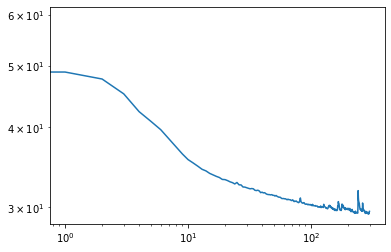

In [11]:
plt.plot(wd.epoch_loss_arr)
plt.xscale('log')
plt.yscale('log')
plt.show()

[5, 0, 4, 1, 9, 2, 1, 3]
[1, 4, 3, 5, 3, 6, 1, 7]
[2, 8, 6, 9]


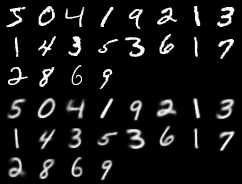

In [12]:
test_idxes = range(20)
test_datas = torch.stack([dataset[i][0] for i in test_idxes])
test_labels = [dataset[i][1] for i in test_idxes]
pred_datas, _, _, _ = model.forward(test_datas.to(model.hpm['device']))
pred_datas = pred_datas.data.cpu()

for i in range(len(test_idxes)//8):
    print(test_labels[i*8:(i+1)*8])
print(test_labels[len(test_labels)//8 * 8:])

# test_img = ToPILImage()(torchvision.utils.make_grid(test_datas, nrow=8))
# test_img.show()
# pred_img = ToPILImage()(torchvision.utils.make_grid(pred_datas, nrow=8))
# pred_img

concat_datas = torch.concat(
    [torchvision.utils.make_grid(test_datas, nrow=8),
    torchvision.utils.make_grid(pred_datas, nrow=8)], dim=1)
ToPILImage()(concat_datas)


## Save

In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
timestamp

'20220423_165050'

In [14]:
save_names = {
    'model': './data/VAE-MLP@MNIST-model-'+timestamp+'.pth',
    'state_dict': './data/VAE-MLP@MNIST-state_dict-'+timestamp+'.pth',
    'loss': './data/VAE-MLP@MNIST-loss-'+timestamp+'.pth',
}

# os.chdir(workspace)

torch.save(model.state_dict(), save_names['state_dict'])
# model.load_state_dict(torch.load('./data/VAE-MLP@MNIST-state_dict.pth'))
torch.save(model, save_names['model'])
# model =torch.load('./data/VAE-MLP@MNIST-model.pth')
torch.save(wd.epoch_loss_arr, save_names['loss'])
